In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize, signal, integrate

from scifit.solvers import FitSolver1D

from sklearn import metrics
from sklearn.linear_model import LinearRegression

Checks:

 - https://www.wolframalpha.com/input?i=solve+%7Bc1+%3D+1%2F%28k1*V%29*%281-k2%29%3B+c2+%3D+-+1%2F%28k1*V%29*k2*n0%7D+for+%7Bk1%2C+k2%7D
 - https://www.wolframalpha.com/input?i=integral+b*x%2F%28a*%28n0-x%29%29


In [2]:
np.random.seed(12345)

In [3]:
R = 8.31446261815324  # J/mol.K
T0 = 292.05           # K
p0 = 101600           # Pa
V = 190e-3            # L of isopropanol
m = 2.7677            # g of Raney Nickel
rho = 785             # kg/m³ or g/L
M = 60.1              # g/mol
n0 = rho/M            # mol/L

In [4]:
n0

13.061564059900165

In [5]:
k = 8.765e-6
b = 8.901e5
a = 1.234e4

In [6]:
b/a

72.13128038897894

In [7]:
def model(x, k, a, b, n0=n0):
    return k*(a*(n0 - x))/(1 + a*(n0 - x) + b*x)

In [8]:
def ode(t, x, k, a, b, n0):
    return np.array([
        model(x, k, a, b, n0)
    ])

In [9]:
t = np.linspace(0, 10000, 50)

In [10]:
sol = integrate.solve_ivp(ode, [t.min(), t.max()], y0=[0], args=(k, a, b, n0), t_eval=t)

In [11]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.041e+02 ...  9.796e+03  1.000e+04]
        y: [[ 0.000e+00  1.780e-03 ...  7.164e-02  7.291e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 56
     njev: 0
      nlu: 0

In [12]:
xi = sol.y[0,:]

In [13]:
r = ode(t, xi, k, a, b, n0).squeeze()

In [14]:
tn = (t + 5*np.random.normal(size=t.size)).round(1)

In [15]:
data = pd.DataFrame({"t": t, "tn": tn, "xi": xi, "r": r})

In [16]:
data["rinv"] = 1/data["r"]
data["A"] = (n0 - data["xi"])/V
data["B"] = data["xi"]/V
data["x1"] = data["xi"]/(n0 - data["xi"])
data["x2"] = np.log((n0 - data["xi"])/n0)

In [17]:
data["dxidt"] = data["xi"].diff()/data["tn"].diff()

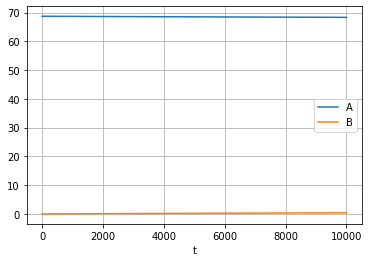

In [18]:
axe = data.plot(x="t", y="A")
data.plot(x="t", y="B", ax=axe)
axe.grid()

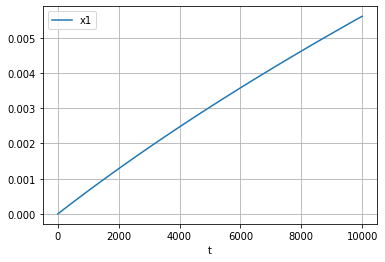

In [19]:
axe = data.plot(x="t", y="x1")
axe.grid()

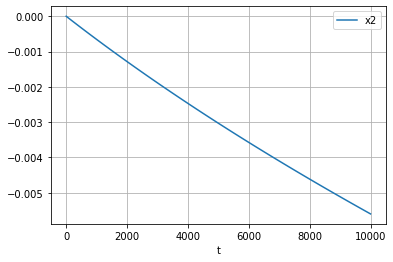

In [20]:
axe = data.plot(x="t", y="x2")
axe.grid()

In [21]:
coefs = np.polyfit(data["tn"], xi, 3)
data["xiP3"] = np.polyval(coefs, data["tn"])
data["rP3"] = np.polyval(np.polyder(coefs, m=1), data["tn"])

In [22]:
data["xiSG"] = signal.savgol_filter(data["xi"], 7, 3)
data["rSG"] = signal.savgol_filter(data["xi"], 7, 3, deriv=1, delta=np.diff(t)[0])

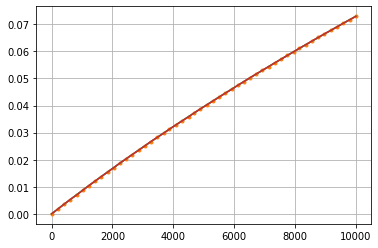

In [23]:
fig, axe = plt.subplots()
axe.plot(data["t"], data["xi"])
axe.plot(data["tn"], data["xi"], linestyle="None", marker=".")
axe.plot(data["tn"], data["xiP3"])
axe.plot(data["tn"], data["xiSG"])
axe.grid()

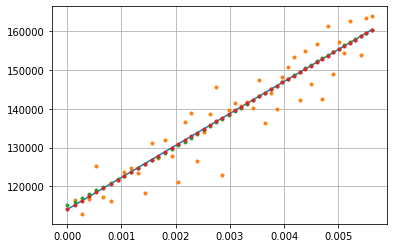

In [24]:
fig, axe = plt.subplots()
axe.plot(data["x1"], data["rinv"])
axe.plot(data["x1"], 1/data["dxidt"], linestyle="None", marker=".")
axe.plot(data["x1"], 1/data["rP3"], linestyle="None", marker=".")
axe.plot(data["x1"], 1/data["rSG"], linestyle="None", marker=".")
axe.grid()

In [25]:
regressor = LinearRegression(fit_intercept=False)

In [26]:
q = data["t"] <= 10000
regressor.fit(data.loc[q, ["xi", "x2"]].values, data.loc[q, "t"].values)

LinearRegression(fit_intercept=False)

In [27]:
c1, c2 = regressor.coef_
c1, c2

(-8126826.311277762, -107638954.55029608)

In [28]:
regressor.score(data[["xi", "x2"]].values, data["t"])

0.999999994675496

In [29]:
n0/((n0*c1 - c2))

8.766785338975014e-06

In [30]:
-c2/(n0*c1 - c2)

72.24614175810628

In [31]:
def naive(x, k1, k2):
    return (1/k1) * ((1 - k2)*x - k2*n0*np.log((n0 - x)/n0)) 

In [75]:
optimize.curve_fit(naive, data["xi"].values, data["t"].values)

(array([8.76678534e-06, 7.22461419e+01]),
 array([[5.08578518e-20, 2.96044792e-12],
        [2.96044792e-12, 1.80105024e-04]]))

In [68]:
class Model(FitSolver1D):
    @staticmethod
    def model(x, k1, k2):
        return (1/k1) * ((1 - k2)*x[:,0] - k2*n0*np.log((n0 - x[:,0])/n0)) 

In [76]:
model = Model()
sol = model.fit(data[["xi"]].values, data["tn"].values, sigma=5.)

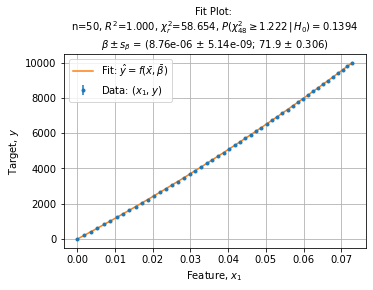

In [81]:
axe = model.plot_fit()

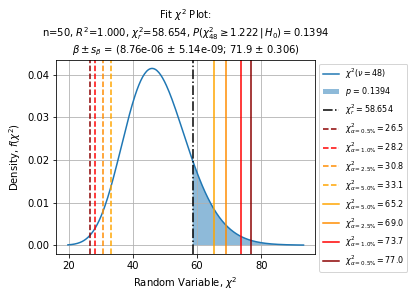

In [82]:
axe = model.plot_chi_square()

In [83]:
#axe = model.plot_kolmogorov()

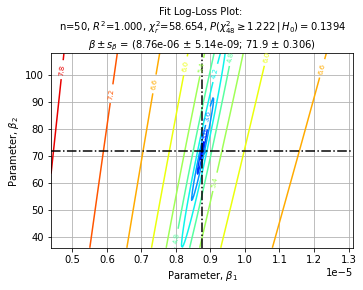

In [91]:
axe = model.plot_loss(factor=5, log_loss=True, log_x=False, log_y=False, resolution=300)
#axe.grid(which="both")

In [33]:
lbth = LinearRegression(fit_intercept=True)
lbth.fit(data[["x1"]].values, data["rinv"].values)

LinearRegression()

In [34]:
c1 = lbth.intercept_
c2 = lbth.coef_[0]

In [35]:
c1, c2

(114090.83904794423, 8229467.9513102295)

In [36]:
k1 = 1/c1
k2 = c2/c1

In [37]:
k1, k2

(8.764945620040285e-06, 72.13083907509849)